In [1]:
from dask.distributed import Client
import dask
import matplotlib.pyplot as plt

import os
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["NUMEXPR_NUM_THREADS"] = "1" 
os.environ["OMP_NUM_THREADS"] = "1" 
import numpy as np

In [2]:
import os
os.chdir("/scratch/ak1774/runs")

In [3]:
client = Client(n_workers=10, threads_per_worker=1)

In [4]:
def set_up_worker():
    import os
    os.environ["MKL_NUM_THREADS"] = "1" 
    os.environ["NUMEXPR_NUM_THREADS"] = "1" 
    os.environ["OMP_NUM_THREADS"] = "1" 
    
client.run(set_up_worker);

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from es_map import es_update
from es_map import distributed_evaluate
from es_map.interaction import interaction
from es_map import behavior_map
from es_map import novelty_archive
from es_map import map_elite_utils

In [7]:
config = {
    "env_id" : "DamageAnt-v2",
    "policy_args" : {
        "init" : "normc",
        "layers" :[256, 256],
       "activation" : 'tanh',
       "action_noise" : 0.01,
    },
    "env_args" : {
        "use_norm_obs" : True,
    },
    
    "ES_NUM_INITIAL_RANDOM_INDIVIDUALS_TO_POPULATE_MAP" : 20,
    
    "ES_NUM_GENERATIONS" : 1000,
    "ES_popsize" : 100,
    "ES_sigma" : 0.02,
    "ES_EVALUATION_BATCH_SIZE" : 5,
    "ES_lr" : 0.01,
    
    "ES_CENTRAL_NUM_EVALUATIONS" : 30,
    "ES_STEPS_UNTIL_NEW_PARENT_SELECTION" : 5,
    
    "GA_MAP_ELITES_NUM_GENERATIONS" : 1000,
    
    "GA_CHILDREN_PER_GENERATION" : 200,
    "GA_NUM_EVALUATIONS" : 10,
    
    "GA_MULTI_PARENT_MODE" : True,
    "GA_PARENT_SELECTION_MODE" : "rank_proportional",  # "uniform", "rank_proportional"
    "GA_RANK_PROPORTIONAL_SELECTION_AGRESSIVENESS" : 1.0,  # 0.0 uniform, 1.0 normal , higher more agressive
    "GA_MUTATION_POWER" : 0.02,
    
    "map_elites_grid_description" : {
        "bc_limits" : [[0,1],[0,1],[0,1],[0,1]],
        "grid_dims" : [6,6,6,6],
    },
    
    # BMAP settings
    "BMAP_type_and_metrics" : ["single_map",    # type can be: "single_map","multi_map","nd_sorted_map" 
                               ["fitness"]],    # metric can be: ["f"],["f",e], ["f,e,i"], etc... 
    "ES_UPDATES_MODES_TO_USE" : ["fitness"],#"evolvability","innovation"], # list of updates to use
    "ES_PARENT_SELECTION_MODE" : "rank_proportional",  # "uniform", "rank_proportional"
    "ES_RANK_PROPORTIONAL_SELECTION_AGRESSIVENESS" : 1.0,  # 0.0 uniform, 1.0 normal , higher more agressive
    
    "NOVELTY_CALCULATION_NUM_NEIGHBORS" : 10,
    
    
    "CHECKPOINT_FREQUENCY" : 100,
    "PLOT_FREQUENCY" : 100,
}

In [8]:
wandb_logging = True
if wandb_logging is True:
    import wandb
    config
    #wandb.config = config
    wandb.init(project="evolvability_map_elites", entity="adam_katona")
    wandb.run.name = "me_es_test"
    wandb.run.config.update(config)

    run_name = wandb.run.dir.split("/")[-2]
    run_checkpoint_path = "/scratch/ak1774/runs/large_files/" + run_name
    os.makedirs(run_checkpoint_path,exist_ok=True)

wandb: Currently logged in as: adam_katona (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [9]:
import itertools
        
def create_id_generator():
    counter = itertools.count()
    def get_next_id():
        return next(counter)
    return get_next_id
    
get_next_individual_id = create_id_generator()

In [10]:
####################
## SINGLE MAP ######
####################

staring run_es_map_elites_single_map
CREATING RANDOM INDIVIDUAL
new parent selected
new update started
0 1 1002.7893505029407
new update started
1 2 1002.7893505029407
new update started
2 2 1002.7893505029407
new parent selected
new update started
3 2 1002.7893505029407
new update started
4 3 1002.7893505029407
new update started
5 4 1002.7893505029407
new parent selected
new update started
6 4 1002.7893505029407
new update started
7 4 1002.7893505029407
new update started
8 4 1002.7893505029407
new parent selected
new update started
9 5 1002.7893505029407
new update started
10 5 1002.7893505029407
10
generation_number 10
nonempty_cells 5
nonempty_ratio 0.0038580246913580245
best_fitness_so_far 1002.7893505029407
best_evolvability_so_far 0.5636820850118095
current_children_fitness_mean 931.210173423072
current_children_fitness_std 46.655241378000134
current_eval_fitness 979.6856014213819
current_evolvability 0.512684284722222
current_innovation 0.9483553425012256
new update started
11

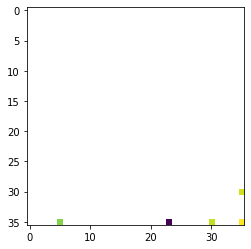

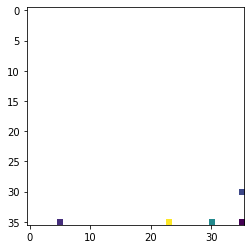

In [11]:
from es_map import es_map_elites
es_map_elites.run_es_map_elites_single_map(client,config,wandb_logging=wandb_logging)


In [12]:
path = "/scratch/ak1774/runs/large_files/run-20220105_093754-984vqkhn/"
b_map_data = np.load(path+"b_map.npy",allow_pickle=True)
b_map = behavior_map.Grid_behaviour_map(config)
b_map.data = b_map_data

b_archive = novelty_archive.NoveltyArchive(bc_dim = len(config["map_elites_grid_description"]["grid_dims"]))
b_archive.load_from_file(path+"b_archive.npy")  


In [17]:
non_empty = b_map.get_non_empty_cells()

In [19]:
for val in non_empty:
    print(val["elite"]["parent_ID"]," -> ",val["elite"]["ID"])

5  ->  6
2  ->  10
4  ->  5
1  ->  2
0  ->  1


In [22]:
for val in non_empty:
    print(val["elite"]["innovation"])

0.8819801175926912
1.1248987699199067
1.0178191986263412
0.8490709091754112
0.0


In [20]:
non_empty

array([{'elite': {'params': array([-0.07261   ,  0.08643386, -0.07179888, ...,  0.02999999,
        0.08999998, -0.01      ], dtype=float32), 'ID': 6, 'parent_ID': 5, 'generation_created': 5, 'child_eval': {'noise_descriptors': [(17928319, 1), (91375039, 1), (18054745, 1), (33682388, 1), (56855153, 1), (99774933, 1), (17928319, -1), (91375039, -1), (18054745, -1), (33682388, -1), (56855153, -1), (99774933, -1)], 'fitnesses': array([ 993.4061404 ,  990.24855026,  999.52314359, 1001.76143257,
        982.95016805,  993.24580099,  985.82323806,  991.18547174,
        994.42099981,  995.36613476,  979.20012972,  994.96111701]), 'bcs': array([[0.981, 0.968, 0.821, 0.969],
       [0.974, 0.971, 0.013, 0.969],
       [0.946, 0.983, 0.002, 0.99 ],
       [0.957, 0.954, 0.949, 0.966],
       [0.869, 0.687, 0.902, 0.011],
       [0.002, 0.988, 0.952, 0.987],
       [0.972, 0.975, 0.971, 0.977],
       [0.603, 0.854, 0.742, 0.869],
       [0.989, 0.031, 0.975, 0.891],
       [0.989, 0.001, 0.986,

In [18]:
# TODO dump config into large file folder

DEBUG = True
if DEBUG:
    config["ES_NUM_GENERATIONS"] = 15
    config["ES_popsize"] = 12
    config["ES_NUM_INITIAL_RANDOM_INDIVIDUALS_TO_POPULATE_MAP"] = 1
    config["ES_CENTRAL_NUM_EVALUATIONS"] = 3
    config["ES_STEPS_UNTIL_NEW_PARENT_SELECTION"] = 3
    


generation_number = 0
evaluations_so_far = 0
best_fitness_so_far = 0
best_model_so_far = None
best_evolvability_so_far = 0



b_map = behavior_map.Grid_behaviour_map(config)
b_archive = novelty_archive.NoveltyArchive(bc_dim = len(config["map_elites_grid_description"]["grid_dims"]))

while True:
    if generation_number >= config["ES_NUM_GENERATIONS"]:
        print("Done, reached iteration: ",config["ES_NUM_GENERATIONS"])
        break
        
    non_empty_cells = b_map.get_non_empty_cells()
    
    ##############################################
    ## Populate the map with random individuals ##
    ##############################################
    if len(non_empty_cells) == 0: # no parent available
        
        for _ in range(config["ES_NUM_INITIAL_RANDOM_INDIVIDUALS_TO_POPULATE_MAP"]):
            print("CREATING RANDOM INDIVIDUAL")
            new_individual_params = map_elite_utils.get_random_individual(config)

            # for the single map we are only interested in the fitness
            # but we maybe should calculate evolvability and innovation so we can compare them to the other algos

            eval_results = distributed_evaluate.evaluate_individual_repeated(theta=new_individual_params,
                                                             obs_mean=None,obs_std=None,eval=True,
                                                             config=config,repeat_n=config["ES_CENTRAL_NUM_EVALUATIONS"])

            # TODO, maybe also evaluate children to get evolvability
            
            # insert the new individual in the map
            map_coords = b_map.get_cell_coords(eval_results["bc"])
            # Add to map if fitness is larger, or map is empty
            
            # id the cell occupied?
            needs_adding = False
            if b_map.data[map_coords] is None:
                needs_adding = True
            elif b_map.data[map_coords]["elite"]["eval_fitness"] < eval_results["fitness"]:
                needs_adding = True
            
            if needs_adding is True:      
                new_individual = {
                    "params" : new_individual_params,
                    "ID" : get_next_individual_id(),
                    "parent_ID" : None,
                    "generation_created" : generation_number,
                    
                    "child_eval" : None, # TODO
                    
                    "eval_fitness" : eval_results["fitness"],
                    "eval_bc" : eval_results["bc"],
                    
                    "obs_stats" : {  
                        "obs_sum" : None,  # TODO handle obs stats
                        "obs_sq" : None,
                        "obs_count" : None,
                    },
                    
                    "evolvability" : None,
                    "innovation" : None,

                    "innovation_over_time" : None,  # innovation decreases over time, as we add new individuals to the archive
                    #{  
                    #    generation_number : innovation_at_generation,
                    #    generation_number : innovation_at_generation,
                    #},
                }
                
                new_cell = {
                    "elite" : new_individual
                }
                b_map.data[map_coords] = new_cell
                
                if new_individual["eval_fitness"] > best_fitness_so_far:
                    best_fitness_so_far = new_individual["eval_fitness"]
            

    ######################
    ## PARENT SELECTION ##
    ######################
    else:
        if config["ES_PARENT_SELECTION_MODE"] == "uniform":
            parent_cell = np.random.choice(non_empty_cells)  # NOTE, here goes cell selection method
        elif config["ES_PARENT_SELECTION_MODE"] == "rank_proportional":
            sorted_cells = sorted(non_empty_cells,key=lambda x : x["elite"]["eval_fitness"])                
            selected_index = map_elite_utils.rank_based_selection(num_parent_candidates=len(sorted_cells),
                                                     num_children=None, # only want a single parent
                                                     agressiveness=config["ES_RANK_PROPORTIONAL_SELECTION_AGRESSIVENESS"])
            parent_cell = sorted_cells[selected_index]
            
        
        current_individual = parent_cell["elite"]
            
        # decide on update mode (explore,exploit,build_evolvability)
        es_update_mode = np.random.choice(config["ES_UPDATES_MODES_TO_USE"])
            
        for update_step_i in range(config["ES_STEPS_UNTIL_NEW_PARENT_SELECTION"]):
            
            #######################
            ## EVALUATE CHILDREN ##
            #######################
            # does this cell already have cached evaluations?, then we can reuse it
            if current_individual["child_eval"] is None:  # maybe this should never happen, we will see
                #current_individual -> obs_mean,obs_std # TODO
                obs_mean,obs_std = None,None
                current_individual["child_eval"] = distributed_evaluate.es_evaluate_children(client,current_individual["params"],obs_mean,obs_std,config)
                
                
            ##################
            ## DO ES UPDATE ##
            ##################
            updated_theta = es_update.es_update(current_individual["params"],current_individual["child_eval"],
                                                config,es_update_type=es_update_mode,novelty_archive=b_archive)
            
            if current_individual["evolvability"] is None:
                current_evolvability = es_update.calculate_behavioural_variance(child_evaluations,config)
                current_innovation = es_update.calculate_innovativeness(child_evaluations,b_archive,config)
                current_individual["evolvability"] = current_evolvability
                current_individual["innovation"] = current_innovation
                
            
            
            ############################
            ## EVALUATE UPDATED THETA ##
            ############################
            
            updated_eval_results = distributed_evaluate.evaluate_individual_repeated(theta=updated_theta,
                                                             obs_mean=None,obs_std=None,eval=True,
                                                             config=config,repeat_n=config["ES_CENTRAL_NUM_EVALUATIONS"])
            
            ##################################
            ## EVALUATE CHILDREN OF UPDATED ##
            ##################################
            
            updated_child_eval = distributed_evaluate.es_evaluate_children(client,updated_theta,obs_mean=None,obs_std=None,config=config)
            updated_evolvability = es_update.calculate_behavioural_variance(updated_child_eval,config)
            updated_innovation = es_update.calculate_innovativeness(updated_child_eval,b_archive,config)
            
            new_individual = {
                "params" : updated_theta,  # 1d torch tensor containing the parameters 
                "ID" : get_next_individual_id(),
                "parent_ID" : current_individual["ID"],
                "generation_created" : generation_number,

                "child_eval" : updated_child_eval,

                "eval_fitness" : updated_eval_results["fitness"],
                "eval_bc" : updated_eval_results["bc"],

                "obs_stats" : {   # TODO
                    "obs_sum" : None,
                    "obs_sq" : None,
                    "obs_count" : None,
                },

                "evolvability" : updated_evolvability,
                "innovation" : updated_innovation,

                "innovation_over_time" : {   # innovation decreases over time, as we add new individuals to the archive
                    generation_number : updated_innovation,
                },
            }
            
            if new_individual["evolvability"] > best_evolvability_so_far:
                best_evolvability_so_far = new_individual["evolvability"]
            if new_individual["eval_fitness"] > best_fitness_so_far:
                best_fitness_so_far = new_individual["eval_fitness"]
            
            #########################
            ## INSERT INTO ARCHIVE ##
            #########################
            
            # Weather or not we insert it, we add it to the behavior archive
            b_archive.add_to_archive(new_individual["eval_bc"])
            
            map_coords = b_map.get_cell_coords(new_individual["eval_bc"])
            if b_map.data[map_coords] is None:
                new_cell = { "elite" : new_individual }
                b_map.data[map_coords] = new_cell
            elif b_map.data[map_coords]["elite"]["eval_fitness"] < new_individual["eval_fitness"]:
                b_map.data[map_coords]["elite"] = new_individual 
                
            ################################
            ## PREPARE FOR NEXT ITERATION ##
            ################################
            current_individual = new_individual
            
            
            ########################
            ## EVERY STEP LOGGING ##
            ########################

            non_empty_cells = b_map.get_non_empty_cells()
            print(generation_number,len(non_empty_cells),best_fitness_so_far)

            # Do the step logging 
            step_logs = {
                "generation_number" : generation_number,
                "nonempty_cells" : len(non_empty_cells),
                "nonempty_ratio" : float(len(non_empty_cells)) / b_map.data.size,
                "best_fitness_so_far" : best_fitness_so_far,
                "best_evolvability_so_far" : best_evolvability_so_far,
                "current_children_fitness_mean" : np.mean(new_individual["child_eval"]["fitnesses"]),
                "current_children_fitness_std" : np.std(new_individual["child_eval"]["fitnesses"]),
                "current_eval_fitness" : new_individual["eval_fitness"],
                "current_evolvability" : new_individual["evolvability"],
                "current_innovation" : new_individual["innovation"],
            }
            if wandb_logging is True:
                wandb.log(step_logs)
            
            ####################
            ## N STEP LOGGING ##
            ####################

            # Do the n-step logging
            if generation_number % config["PLOT_FREQUENCY"] == 10:
                # do plot map
                # save map without heavy stuff???
                fig_f,ax = map_elite_utils.plot_4d_map(b_map,metric="eval_fitness")
                fig_evo,ax = map_elite_utils.plot_4d_map(b_map,metric="evolvability")
                n_step_log = {
                    "b_map_plot" : fig_f,
                    "b_map_evolvability_plot" : fig_evo, 
                }
                if wandb_logging is True:
                    wandb.log(n_step_log)

                # also print some stuff to console
                print(generation_number)
                for k,v in step_logs.items():
                    print(k,v)
            
            ###################
            ## CHECKPOINTING ##
            ###################

            # Do checkpointing
            if generation_number % config["CHECKPOINT_FREQUENCY"] == 10:
                np.save(run_checkpoint_path+"/b_map.npy",b_map.data,allow_pickle=True)
                b_archive.save_to_file(run_checkpoint_path+"/b_archive.npy")
                
        
            generation_number += 1
            
            
################
## FINAL SAVE ##
################
print("Doing final save!")
np.save(run_checkpoint_path+"/b_map.npy",b_map.data,allow_pickle=True)
b_archive.save_to_file(run_checkpoint_path+"/b_archive.npy")
print("Final save done: ", run_checkpoint_path)
            
            
            
        
        
        
        
        
        
        

CREATING RANDOM INDIVIDUAL
1 2 1007.1448011801327
3 2 1007.1448011801327
5 3 1007.1448011801327
7 4 1007.1448011801327
9 4 1007.1448011801327
11 5 1007.1448011801327
13 6 1007.1448011801327
15 6 1007.1448011801327
17 6 1007.1448011801327
Done, reached iteration:  15
Doing final save!


NameError: name 'run_checkpoint_path' is not defined

In [8]:
def select_parent_es_me(non_empty_cells,config,selection_metric):
    if len(non_empty_cells) == 0:
            parent_cell = None
            parent_params = get_random_individual(config)
            parent_obs_mean = None
            parent_obs_std = None
            
    else:
        if config["ES_PARENT_SELECTION_MODE"] == "uniform":
            parent_cell = np.random.choice(non_empty_cells)  # NOTE, here goes cell selection method
        elif config["ES_PARENT_SELECTION_MODE"] == "rank_proportional":
            sorted_cells = sorted(non_empty_cells,key=lambda x : x["selection_metric"])                
            selected_index = rank_based_selection(num_parent_candidates=len(sorted_cells),
                                                     num_children=None, # only want a single parent
                                                     agressiveness=config["GA_RANK_PROPORTIONAL_SELECTION_AGRESSIVENESS"])
            parent_cell = sorted_cells[selected_index]

        else:
            raise "NOT IMPLEMENTED"

    return parent_cell

In [ ]:
DEBUG = False
if DEBUG is True:
    config["ES_NUM_GENERATIONS"] = 30
    config["ES_popsize"] = 20
    config["ES_CENTRAL_NUM_EVALUATIONS"] = 4
    

b_archive = novelty_archive.NoveltyArchive(bc_dim = len(config["map_elites_grid_description"]["grid_dims"]))
    
run_name = wandb.run.dir.split("/")[-2]
run_checkpoint_path = "/scratch/ak1774/runs/large_files/" + run_name

evaluations_per_generation = config["ES_popsize"] + config["ES_CENTRAL_NUM_EVALUATIONS"] 
B_MAP_TYPE = config["BMAP_type_and_metrics"][0]
B_MAP_METRICS = config["BMAP_type_and_metrics"][1]

generation_number = 0
evaluations_so_far = 0
best_fitness_so_far = 0
best_model_so_far = None
    

# there are several kinds of modes
# selection mode (which type of parent we select (this one is only available for multi map))
# update mode (which type of es update we do)
# archive mode (which type of map we try to insert it to (only available for multi map))
    
# MODES Summary
# I decided not to have selection mode, we select with uniform prob from each map 
# (this would be only be relevent if we want to have different update probabilities for parents from different maps)
# I decided not to have archive mode, we try to archive into all the maps

    
if B_MAP_TYPE == "single_map" or B_MAP_TYPE == "nd_sorted_map":
    b_map = behavior_map.Grid_behaviour_map(config)
    while True
        if generation_number >= config["ES_NUM_GENERATIONS"]:
            print("Done, reached iteration: ",config["ES_NUM_GENERATIONS"])
            break
            
        
    
        non_empty_cells = b_map.get_non_empty_cells(config)
        if len(non_empty_cells) == 0: # no parent available
            parent = None # TODO prepare new individual NOTE this should be different because we want to evaluate the parent not the child here
        
            # evaluate new individual
            # can also calculate children to get evolvability and innovation
        
        
        
        else:
            if B_MAP_TYPE == "single_map":
                # select parent cell
                selection_metric = "eval_fitness"
                selected_parent_cell = select_parent_es_me(non_empty_cells,config,selection_metric)
                parent = selected_parent_cell["elite"]

            elif B_MAP_TYPE == "nd_sorted_map":
                # select parent cell
                # for slectinf cells with nd sorted map, we cannot simply use a metric.
                # ech cell contains a tradeoff between objectives
                # let us do uniform selection from each cell
                parent_cell = np.random.choice(non_empty_cells)
                
                # now let us select an individual form the non dominated front of elites in the cell
                parent = np.random.choice(parent_cell["elites"])


        
        
        # decide on update mode (explore,exploit,build_evolvability)
        es_update_mode = np.random.choice(config["ES_UPDATES_MODES_TO_USE"])
    
    
    
    
    
elif B_MAP_TYPE == "multi_map":
    b_map = behavior_map.Grid_behaviour_multi_map(config)
    while True:
        if generation_number >= config["ES_NUM_GENERATIONS"]:
            print("Done, reached iteration: ",config["ES_NUM_GENERATIONS"])
            break
        
            # Decide on selection mode (which map we select a parent from) Should we just do uniform from ech map?
            # Should which update we do depend on which map we select the parent from?
            
            # Decide on update mode (it makes sense to mix this up, eg we want to use the evolvable parent to find fit child)
            # Decide on archive mode (for fitness we can always test archiving, for innov and evolvability, we need a new evaluation to evaluate)
            # once we do the new evaluation, we can try to archive it into all the maps
        
            non_empty_cells = b_map.get_non_empty_cells(config)
        
        
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    generation_number += 1


In [ ]:
####################
## ND SORTED MAP ###
####################

In [ ]:
b_map = behavior_map.Grid_behaviour_map(config)
while True:
    if generation_number >= config["ES_NUM_GENERATIONS"]:
        print("Done, reached iteration: ",config["ES_NUM_GENERATIONS"])
        break

In [ ]:
####################
## MULTI MAP #######
####################

In [ ]:
b_map = behavior_map.Grid_behaviour_map(config)
while True:
    if generation_number >= config["ES_NUM_GENERATIONS"]:
        print("Done, reached iteration: ",config["ES_NUM_GENERATIONS"])
        break
        

In [5]:
config["BMAP_type_and_metrics"] = [
    "multi_map",
    ["f","e"],
]

In [16]:
b_map = behavior_map.create_b_map_grid(config)

In [7]:
b_map

In [ ]:
    "BMAP_type_and_metrics" : ["single_map",    # type can be: "single_map","multi_map","nd_sorted_map" 
                               ["fitness"]],    # metric can be: ["f"],["f",e], ["f,e,i"], etc... 

In [17]:
b_map.data[1,4,3,5,2] = 19

In [18]:
b_map.get_non_empty_cells(config,metric="e")

array([19], dtype=object)

In [21]:
b_map.get_cell_coords(bc=[0.5,0.5,0.5,0.5,],config=config,metric="f")

[0, 3, 3, 3, 3]

In [20]:
behavior_map._get_cell_coords([0.5,0.5,0.5,0.5,],config)

(3, 3, 3, 3)